In [1]:
import config_imports
from astropy import units as u
from astropy.coordinates import SkyCoord, CartesianRepresentation, TEME
from astropy.time import Time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


def to_datetime(eos_data: pd.DataFrame):
    eos_data["Datetime"] = eos_data[["Date", "Time", "Time since start (s)"]].apply(lambda x: datetime.datetime.fromisoformat(
        x.iloc[0] + "T" + x.iloc[1] + "Z") + datetime.timedelta(seconds=x.iloc[2] % 1.0), axis=1)
    eos_data = eos_data.drop(columns=["Date", "Time", "Time since start (s)"])
    return eos_data.set_index("Datetime", inplace=False)


eos_data_raw = pd.read_csv(r"EOS Sim Data\Sim2\sat_kinematic_state.CSV")


eos_data = eos_data_raw.drop(columns=["M11", "M12", "M13", "M21", "M22", "M23", "M31", "M32", "M33", 'M11.1', 'M12.1', 'M13.1', 'M21.1',
                                      'M22.1', 'M23.1', 'M31.1', 'M32.1', 'M33.1', 'X (deg/s).1', 'Y (deg/s).1', 'Z (deg/s).1'])

eos_data = to_datetime(eos_data)#.iloc[:10000, :]
time = eos_data.index
time_passed_hours = (time - time[0]).total_seconds()/(3600)

eos_data.columns

quat_OB = eos_data[['Q1', 'Q2', 'Q3', 'Q4']]
quat_OB /= np.linalg.norm(quat_OB, axis=1, keepdims=True)

omega_BO_deg = eos_data[['X (deg/s)', 'Y (deg/s)', 'Z (deg/s)']]

euler_OB = eos_data[['Roll (deg)', 'Pitch (deg)', 'Yaw (deg)']]

pos = eos_data[['X (km)', 'Y (km)', 'Z (km)']]
vel = eos_data[['X (km/s)', 'Y (km/s)', 'Z (km/s)']]

geocentric = eos_data[['Geocentric Latitude (deg)',
                       'Geodetic Latitude (deg)', 'Altitude (km)']]

orbit_elements = eos_data[['Eccentricity', 'Semi-major Axis (km)',
                           'Inclination (deg)', 'Right-ascension of Ascending Node (deg)',
                           'Argument of Perigee (deg)', 'True Anomaly (deg)',
                           'Radius of Perigee (km)', 'Radius of Apogee (km)',
                           'Perigee Altitude (km)', 'Apogee Altitude (km)']]

orbit_ang_rate = eos_data['Orbit Angular Rate (deg/s)']

# convert from TEME to GCRS inertial frame
def teme_to_gcrs(t: datetime.datetime, x_TEME):
    teme = TEME(obstime=Time(t, format="datetime", scale="utc"))
    x_ECI = SkyCoord(CartesianRepresentation(x_TEME[:, 0], x_TEME[:, 1], x_TEME[:, 2], unit=u.km), frame=teme,
                     representation_type='cartesian').transform_to("gcrs").cartesian.xyz.to(u.m).value  # type: ignore
    return x_ECI.T


pos_arr = teme_to_gcrs(time, np.array(pos))
vel_arr = teme_to_gcrs(time, np.array(vel))

Running:   0%|          | 0/30526 [00:00<?, ?it/s]

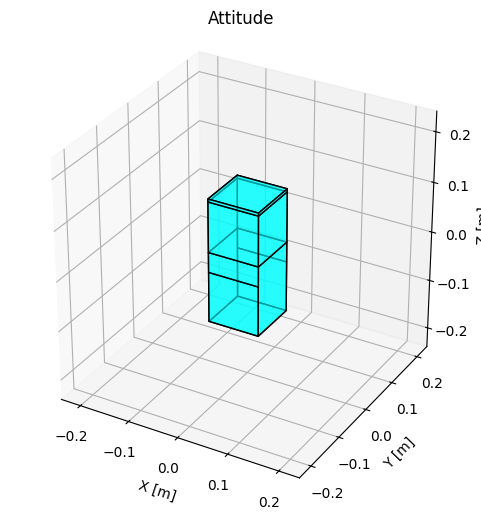

Running:   0%|          | 0/30526 [00:27<?, ?it/s]


KeyboardInterrupt: 

In [4]:
import os

from tqdm import tqdm
from simulation import Simulation
from visualization import SatelliteVisualizer
import time as time_py
from scipy.spatial.transform import Rotation as R


sim = Simulation.from_json(os.path.join(config_imports.PROJECT_DIR, "tudsat-trace_eos.json"))
surfaces = sim.sat.surfaces

viz = SatelliteVisualizer()


with tqdm(total=len(time), desc="Running") as pbar:
    for i, t in enumerate(time):

        R_BO = R.from_quat(quat_OB.iloc[i], scalar_first=False).inv()


        viz.update(surfaces, R_BO)
        time_py.sleep(0.002)
